# Setting up the environment and importing the data

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
train_data = pd.read_csv("train-balanced-sarcasm.csv")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jasinchow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jasinchow/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
train_data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
len(train_data)

1010826

# Data Preprocessing

## Cleaning data

Remove duplicates

In [6]:
train_data['label'].value_counts()

0    505413
1    505413
Name: label, dtype: int64

In [7]:
train_data = train_data.drop_duplicates()

Remove NAs

In [8]:
train_data = train_data.dropna()
train_data = train_data.reset_index(drop = True)

In [9]:
X = train_data['comment']
y = train_data['label']

# 1st LSTM, Basic

## Tokenizing comments

In [40]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
tokenizer_obj = Tokenizer()

tokenizer_obj.fit_on_texts(X)
sequences = tokenizer_obj.texts_to_sequences(X)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

#first set maximum sentence length to be 25. Can be tweaked
X_final = pad_sequences(sequences, padding = 'post', maxlen = 25)

unique tokens -  180583
vocab size - 180584


## Train-Valid-Test split (Manually)

In [41]:
X_final=np.array(X_final)
y_final=np.array(y)

In [42]:
train_index = round(len(X_final) * 3/5)
test_index = round(len(X_final) * 9/10)
X_train = X_final[0:train_index]
X_valid = X_final[train_index:test_index]
X_test = X_final[test_index:]

y_train = y_final[0:train_index]
y_valid = y_final[train_index:test_index]
y_test = y_final[test_index:]

## Initializaion

In [43]:
base_model = Sequential()
base_model.add(Embedding(180584,100,input_length=25))
base_model.add(LSTM(100))
base_model.add(Dense(1,activation = 'sigmoid')) #last layer 1 node
base_model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics=['accuracy']) #binary cross entropy since its classification problem
#base_model.build(X_final.shape)
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 100)           18058400  
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 18,138,901
Trainable params: 18,138,901
Non-trainable params: 0
_________________________________________________________________


## Training

In [44]:
base_model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=25,batch_size=128)

Epoch 1/25
4738/4738 [==============================] - 1151s 243ms/step - loss: 0.5773 - accuracy: 0.6958 - val_loss: 0.5579 - val_accuracy: 0.7102
Epoch 2/25
4738/4738 [==============================] - 1302s 275ms/step - loss: 0.5121 - accuracy: 0.7451 - val_loss: 0.5678 - val_accuracy: 0.7114
Epoch 3/25
4738/4738 [==============================] - 1146s 242ms/step - loss: 0.4510 - accuracy: 0.7847 - val_loss: 0.6072 - val_accuracy: 0.7063
Epoch 4/25
4738/4738 [==============================] - 1063s 224ms/step - loss: 0.3885 - accuracy: 0.8187 - val_loss: 0.6503 - val_accuracy: 0.6963
Epoch 5/25
4738/4738 [==============================] - 1298s 274ms/step - loss: 0.3342 - accuracy: 0.8444 - val_loss: 0.7172 - val_accuracy: 0.6928
Epoch 6/25
4738/4738 [==============================] - 1208s 255ms/step - loss: 0.2924 - accuracy: 0.8642 - val_loss: 0.8289 - val_accuracy: 0.6866
Epoch 7/25
4738/4738 [==============================] - 1232s 260ms/step - loss: 0.2611 - accuracy: 0.8796

## Testing

In [45]:
y_pred = base_model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

In [46]:
accuracy_score(y_test,y_pred)

0.664892406628741

In [47]:
f1_score(y_test, y_pred)

0.6787986837488501

In [49]:
roc_auc_score(y_test,base_model.predict(X_test))

0.70624453798427

# Further Data Preprocessing

## Cleaning texts

Cleaning here is mainly the removal of apostrophes.

No stemming or removal of stop words shall be done

In [10]:
def clean_text(text): #function to clean the text. Mainly for removing apostrophes
    text = text.lower() 
    text = re.sub("'s", " is", text)
    text = re.sub("'m", " am", text)
    text = re.sub("'t", " not", text)
    text = re.sub("'d", " would", text)
    text = re.sub("'ll"," will", text)
    text = re.sub("'ve", " have", text)
    return text

In [11]:
corpus = []
lengths = [] #we keep the lengths to see how much padding to do later
for i in range(0, len(X)):
  text = clean_text(X[i])
  corpus.append(text) #append the list of words to overall list of sentences
  length = len(corpus[i].split())
  lengths.append(length)

Adding space to special characters so these special characters will be tokenized later

In [12]:
for i in range(0,len(corpus)):
    corpus[i] = re.sub('([.,!?()@#$%^&*])', r' \1 ', corpus[i])

## Tokenizing comments

Instead of calling the Tokenizer object directly, I remove the default filters, as I believe special characters can help in the prediction of sarcastic comments.

pad_sequences adds 0's to sentences/vectors with lengths shorter than 25

In [13]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
tokenizer_obj = Tokenizer(
    num_words=None,
    filters="", #change is here
    lower=True, split=' ', char_level=False, oov_token=None,
    document_count=0)

tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

#first set maximum sentence length to be 25. Can be tweaked
X_final = pad_sequences(sequences, padding = 'post', maxlen = 25)

unique tokens -  235427
vocab size - 235428


Finalize the data that will be fed into the model

In [14]:
X_final=np.array(X_final)
y_final=np.array(y)

## Train-Valid-Test split (Manually)

Train : 60%
Validation : 30%
Test : 10%

In [15]:
train_index = round(len(X_final) * 3/5)
test_index = round(len(X_final) * 9/10)
X_train = X_final[0:train_index]
X_valid = X_final[train_index:test_index]
X_test = X_final[test_index:]

y_train = y_final[0:train_index]
y_valid = y_final[train_index:test_index]
y_test = y_final[test_index:]

Alright, data is cleaned and ready to be used by the model.

# Building the GloVe embedding layer

In [73]:
embeddings_index = {}
embedding_dim = 100
f = open("glove/glove.twitter.27B.100d.txt", 'r', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [74]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [75]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=25,
                            trainable=False)

# 3rd LSTM Model, with Dropout

## Initialization

## Training

In [18]:
model2.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=25,batch_size=128)

2021-11-20 12:37:22.005507: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
4738/4738 [==============================] - 225s 47ms/step - loss: 0.5821 - accuracy: 0.6891 - val_loss: 0.5611 - val_accuracy: 0.7042
Epoch 2/25
4738/4738 [==============================] - 204s 43ms/step - loss: 0.5456 - accuracy: 0.7195 - val_loss: 0.5522 - val_accuracy: 0.7140
Epoch 3/25
4738/4738 [==============================] - 213s 45ms/step - loss: 0.5318 - accuracy: 0.7301 - val_loss: 0.5284 - val_accuracy: 0.7320
Epoch 4/25
4738/4738 [==============================] - 240s 51ms/step - loss: 0.5226 - accuracy: 0.7368 - val_loss: 0.5307 - val_accuracy: 0.7298
Epoch 5/25
4738/4738 [==============================] - 229s 48ms/step - loss: 0.5149 - accuracy: 0.7426 - val_loss: 0.5233 - val_accuracy: 0.7363
Epoch 6/25
4738/4738 [==============================] - 225s 47ms/step - loss: 0.5081 - accuracy: 0.7477 - val_loss: 0.5239 - val_accuracy: 0.7368
Epoch 7/25
4738/4738 [==============================] - 216s 46ms/step - loss: 0.5034 - accuracy: 0.7507 - val_loss: 0

## Testing

In [19]:
y_pred = model2.predict(X_test)
y_pred = np.round(y_pred).astype(int)

In [33]:
model2.predict(X_test)

array([[0.46290022],
       [0.76631683],
       [0.22186878],
       ...,
       [0.70319855],
       [0.5320522 ],
       [0.28534532]], dtype=float32)

In [20]:
accuracy_score(y_test, y_pred)

0.7382438783081869

In [34]:
roc_auc_score(y_test,model2.predict(X_test))

0.8157664930996337

In [29]:
f1_score(y_test, y_pred)

0.7437752404195357

In [35]:
y_pred = model2.predict(X_test)

# 2nd LSTM Model

## Initialization

In [ ]:
model3 = Sequential()
model3.add(embedding_layer)
model3.add(LSTM(100, return_sequences = True))
model3.add(LSTM(100)
model3.add(Dense(1,activation = 'sigmoid')) #last layer 1 node
model3.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics=['accuracy']) #binary cross entropy since its classification problem
model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           23542800  
_________________________________________________________________
lstm_8 (LSTM)                (None, 25, 100)           80400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 23,703,701
Trainable params: 160,901
Non-trainable params: 23,542,800
_________________________________________________________________


## Training

In [87]:
model3.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=25,batch_size=128)

Epoch 1/25
4738/4738 [==============================] - 437s 91ms/step - loss: 0.5784 - accuracy: 0.6923 - val_loss: 0.5463 - val_accuracy: 0.7165
Epoch 2/25
4738/4738 [==============================] - 424s 90ms/step - loss: 0.5419 - accuracy: 0.7233 - val_loss: 0.5421 - val_accuracy: 0.7222
Epoch 3/25
4738/4738 [==============================] - 409s 86ms/step - loss: 0.5271 - accuracy: 0.7339 - val_loss: 0.5308 - val_accuracy: 0.7295
Epoch 4/25
4738/4738 [==============================] - 443s 93ms/step - loss: 0.5164 - accuracy: 0.7414 - val_loss: 0.5362 - val_accuracy: 0.7293
Epoch 5/25
4738/4738 [==============================] - 524s 111ms/step - loss: 0.5074 - accuracy: 0.7479 - val_loss: 0.5226 - val_accuracy: 0.7383
Epoch 6/25
4738/4738 [==============================] - 605s 128ms/step - loss: 0.4990 - accuracy: 0.7533 - val_loss: 0.5261 - val_accuracy: 0.7362
Epoch 7/25
4738/4738 [==============================] - 614s 130ms/step - loss: 0.4913 - accuracy: 0.7590 - val_loss

## Testing

In [78]:
y_pred = model3.predict(X_test)
y_pred = np.round(y_pred).astype(int)

In [ ]:
accuracy_score(y_test, y_pred)

0.7176947811031412

In [80]:
roc_auc_score(y_test,model.predict(X_test))

0.7911966176547351

In [81]:
f1_score(y_test, y_pred)

0.7143686560291498

Training accuracy : 81.16%, Validation accuracy : 72.12%, Test Accuracy = 72.32%

There seems to be some overfitting occuring. I will add dropout and see how the model performs now

# LSTM with Dropouts

## 0.1

In [95]:
model5 = Sequential()
model5.add(embedding_layer)
model5.add(LSTM(100, dropout = 0.1,return_sequences = True))
model5.add(LSTM(100, dropout = 0.1))
model5.add(Dense(1,activation = 'sigmoid')) #last layer 1 node
model5.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics=['accuracy']) #binary cross entropy since its classification problem
model5.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           23542800  
_________________________________________________________________
lstm_16 (LSTM)               (None, 25, 100)           80400     
_________________________________________________________________
lstm_17 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 23,703,701
Trainable params: 160,901
Non-trainable params: 23,542,800
_________________________________________________________________


In [97]:
model5.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=10,batch_size=128)

Epoch 1/10
4738/4738 [==============================] - 357s 75ms/step - loss: 0.5841 - accuracy: 0.6873 - val_loss: 0.5495 - val_accuracy: 0.7149
Epoch 2/10
4738/4738 [==============================] - 357s 75ms/step - loss: 0.5478 - accuracy: 0.7177 - val_loss: 0.5337 - val_accuracy: 0.7268
Epoch 3/10
4738/4738 [==============================] - 364s 77ms/step - loss: 0.5346 - accuracy: 0.7281 - val_loss: 0.5317 - val_accuracy: 0.7300
Epoch 4/10
4738/4738 [==============================] - 365s 77ms/step - loss: 0.5256 - accuracy: 0.7346 - val_loss: 0.5237 - val_accuracy: 0.7346
Epoch 5/10
4738/4738 [==============================] - 364s 77ms/step - loss: 0.5182 - accuracy: 0.7398 - val_loss: 0.5310 - val_accuracy: 0.7319
Epoch 6/10
4738/4738 [==============================] - 346s 73ms/step - loss: 0.5125 - accuracy: 0.7441 - val_loss: 0.5232 - val_accuracy: 0.7377
Epoch 7/10
4738/4738 [==============================] - 354s 75ms/step - loss: 0.5071 - accuracy: 0.7477 - val_loss: 0

In [98]:
y_pred5 = model5.predict(X_test)
y_pred5 = np.round(y_pred5).astype(int)

In [99]:
accuracy_score(y_test, y_pred5)

0.7418748454118229

## 0.2

In [89]:
model4 = Sequential()
model4.add(embedding_layer)
model4.add(LSTM(100, dropout = 0.2,return_sequences = True))
model4.add(LSTM(100, dropout = 0.2))
model4.add(Dense(1,activation = 'sigmoid')) #last layer 1 node
model4.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics=['accuracy']) #binary cross entropy since its classification problem
model4.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           23542800  
_________________________________________________________________
lstm_10 (LSTM)               (None, 25, 100)           80400     
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 23,703,701
Trainable params: 160,901
Non-trainable params: 23,542,800
_________________________________________________________________


In [90]:
model4.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=25,batch_size=128)

Epoch 1/25
4738/4738 [==============================] - 539s 113ms/step - loss: 0.5910 - accuracy: 0.6800 - val_loss: 0.5570 - val_accuracy: 0.7058
Epoch 2/25
4738/4738 [==============================] - 806s 170ms/step - loss: 0.5556 - accuracy: 0.7117 - val_loss: 0.5386 - val_accuracy: 0.7236
Epoch 3/25
4738/4738 [==============================] - 1195s 252ms/step - loss: 0.5428 - accuracy: 0.7212 - val_loss: 0.5298 - val_accuracy: 0.7309
Epoch 4/25
4738/4738 [==============================] - 511s 108ms/step - loss: 0.5343 - accuracy: 0.7281 - val_loss: 0.5270 - val_accuracy: 0.7336
Epoch 5/25
4738/4738 [==============================] - 3236s 683ms/step - loss: 0.5281 - accuracy: 0.7328 - val_loss: 0.5247 - val_accuracy: 0.7338
Epoch 6/25
4738/4738 [==============================] - 3844s 812ms/step - loss: 0.5232 - accuracy: 0.7371 - val_loss: 0.5198 - val_accuracy: 0.7379
Epoch 7/25
4738/4738 [==============================] - 358s 76ms/step - loss: 0.5196 - accuracy: 0.7392 - va

In [93]:
y_pred4 = model4.predict(X_test)
y_pred4 = np.round(y_pred4).astype(int)

In [94]:
accuracy_score(y_test, y_pred4)

0.7449023002720752

## 0.3

In [100]:
model6 = Sequential()
model6.add(embedding_layer)
model6.add(LSTM(100, dropout = 0.3,return_sequences = True))
model6.add(LSTM(100, dropout = 0.3))
model6.add(Dense(1,activation = 'sigmoid')) #last layer 1 node
model6.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics=['accuracy']) #binary cross entropy since its classification problem
model6.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           23542800  
_________________________________________________________________
lstm_18 (LSTM)               (None, 25, 100)           80400     
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 23,703,701
Trainable params: 160,901
Non-trainable params: 23,542,800
_________________________________________________________________


In [101]:
model6.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=10,batch_size=128)

Epoch 1/10
4738/4738 [==============================] - 353s 74ms/step - loss: 0.5950 - accuracy: 0.6774 - val_loss: 0.5733 - val_accuracy: 0.6963
Epoch 2/10
4738/4738 [==============================] - 412s 87ms/step - loss: 0.5629 - accuracy: 0.7059 - val_loss: 0.5526 - val_accuracy: 0.7125
Epoch 3/10
4738/4738 [==============================] - 382s 81ms/step - loss: 0.5506 - accuracy: 0.7153 - val_loss: 0.5320 - val_accuracy: 0.7289
Epoch 4/10
4738/4738 [==============================] - 402s 85ms/step - loss: 0.5428 - accuracy: 0.7215 - val_loss: 0.5305 - val_accuracy: 0.7314
Epoch 5/10
4738/4738 [==============================] - 446s 94ms/step - loss: 0.5370 - accuracy: 0.7260 - val_loss: 0.5236 - val_accuracy: 0.7349
Epoch 6/10
4738/4738 [==============================] - 434s 92ms/step - loss: 0.5333 - accuracy: 0.7287 - val_loss: 0.5229 - val_accuracy: 0.7360
Epoch 7/10
4738/4738 [==============================] - 427s 90ms/step - loss: 0.5300 - accuracy: 0.7305 - val_loss: 0

In [102]:
y_pred6 = model5.predict(X_test)
y_pred6 = np.round(y_pred6).astype(int)

In [103]:
accuracy_score(y_test,y_pred6)

0.7418748454118229

Text(0.5, 1.0, 'Loss against Epochs')

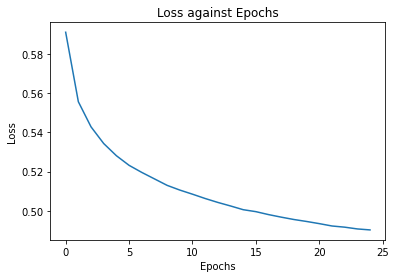

In [123]:
Epochs = list(range(25))
Loss = [0.591,0.5556,0.5428, 0.5343,0.5281, 0.5232, 0.5196, 0.5163, 0.5130, 0.5106, 0.5085, 0.5063, 0.5043, 0.5025, 0.5006, 0.4996, 0.4981, 0.4968, 0.4956, 0.4946, 0.4935, 0.4923, 0.4917, 0.4908, 0.4903]
plt.plot(Epochs, Loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss against Epochs')

# Trying different thresholds

## Saving and loading the model

In [52]:
path = '/Users/jasinchow/Downloads/finalLSTM'
model2.save(path)

INFO:tensorflow:Assets written to: /Users/jasinchow/Downloads/finalLSTM/assets


In [1]:
from tensorflow import keras
reload = keras.models.load_model('/Users/jasinchow/Downloads/finalLSTM')

2021-11-25 17:10:04.820073: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Saving the Tokenizer object

In [54]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Dictionaries of Accuracy, F1 and Recall

In [67]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracies = {0.1:0,0.2:0,0.3:0,0.4:0,0.5:0,0.6:0,0.7:0,0.8:0,0.9:0}
f1 = {0.1:0,0.2:0,0.3:0,0.4:0,0.5:0,0.6:0,0.7:0,0.8:0,0.9:0}
recall = {0.1:0,0.2:0,0.3:0,0.4:0,0.5:0,0.6:0,0.7:0,0.8:0,0.9:0}

In [68]:
for val in thresholds :
    preds = raw_preds > val
    y_pred = preds.astype(int)
    accuracies[val] = accuracy_score(y_test, y_pred)
    f1[val] = f1_score(y_test, y_pred)
    recall[val] = recall_score(y_test, y_pred)

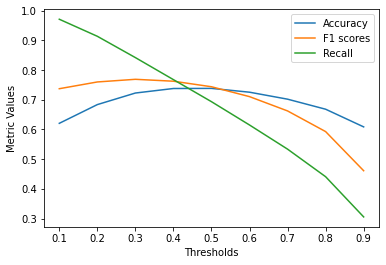

In [71]:
import matplotlib.pyplot as plt
plt.plot(thresholds,accuracies.values(), label = 'Accuracy')
plt.plot(thresholds,f1.values(), label = 'F1 scores')
plt.plot(thresholds,recall.values(), label = 'Recall')
plt.xlabel('Thresholds')
plt.ylabel('Metric Values')
plt.legend()
plt.show()